In [47]:
import numpy as np
import pandas as pd
from itertools import product
from itertools import permutations
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import geopandas
from scipy.spatial import distance
import csv



#global variables (need to initialize here because they are used in multiple different functions):
allShapes = []
eachPoint = np.zeros((2,2,4,2))
bondLengths = {}
bondWidths = {}
atoms = np.zeros((2,2,4,2))
atomsList = []


# Given a set of ions, this function will return the bond lengths for each ion-halide:


In [48]:
df = pd.read_csv('experimental_bond_lengths.csv')

#given a set of ions, this function will return the bond lengths for each ion-halide 
def getBondLengths(atoms, x): #atoms is the list of [1+,2+,3+] and x is the halogen you want the bond length for (ex: Cl, Br, etc.)
    global bondLengths,bondWidths
    bondLengths = {}
    bondWidths = {}
    for i in atoms:
        length = len(i)
        if i[len(i) - 2].isdigit():
            j = i[0:len(i) - 2]
        else:
            j = i[0:len(i) - 1]
            
        if len(df.loc[(df['B']== j) & (df["X"] == x)]) >= 1:
            info = (df.loc[(df['B']==j) & (df["X"] == x)])
            l = info.Dobs.tolist()[0]
            bondLengths[i] = l
            w = info.Dobs2.tolist()[0]
            if w == 0:
                bondWidths[i] = l
            else:
                bondWidths[i] = w
        
        else:
            return(["Bond lengths not found."])
            
    return([bondLengths, bondWidths])

## Generates all the possible combinations/arrangements for a given set of (3) ions:

In [49]:
def validCombinations(atoms, rows, columns):
    possibleCombinations = product(atoms,repeat=rows) #generates all the possible combinations/arrangements for a given set of (3) ions
    possibleCombos = [] #possible combinations that match our 1:2:1 ratio restriction
    #print(len(list(possibleCombinations)))

    counter = 0

    #loops through each combination and puts each ion in that combination into an array (array a on line 11)
    for c in product(possibleCombinations,repeat=columns):
        counter += 1
        a = []
        for i in c:
            for j in i:
                a.append(j)


        #if a (the combination) contains a 1:2:1 ratio, then add it to the array of possible combos 
        if len(atoms) == 4:
            if a.count(atoms[0]) == (rows *columns)/4 and a.count(atoms[1]) == (rows *columns)/4 and (a.count(atoms[2]) + a.count(atoms[3])) == (rows*columns)/2:
                  possibleCombos.append(a)
                    
        else:
            if a.count(atoms[0]) == (rows *columns)/4 and a.count(atoms[1]) == (rows *columns)/4 and (a.count(atoms[2])) == (rows*columns)/2:
                  possibleCombos.append(a)
        
    return(possibleCombos)

## - findBestFit(...) will take in a list of ions, rows, and columns and loop through each possible arrangement for that set.
## - Then, it will calculate the total mismatch for that arrangement. The function will return the arrangement with the smallest total mismatch (total = sum of all the mismatches in that arrangement).
## - All of the arrangements (a listed order) will be saved in a dictionary called allDistances, and the associated total mismatch will be paired with each arrangement.
## - If you want, you can write all of these arrangements + total mismatch pairs to a csv file. To do so, when you call the function, put "True" as the fourth argument, and specify the title of the outputted csv file you wish to make (be sure to include the ".csv" extension in this title name)


In [50]:
def findBestFit(atoms,rows, columns, printCSV = False, title = ""):
    global atomsList
    minDist = 10000000000000000000000000000000
    #minDist is the smallest total mismatch calculated for a combination. It will update as the for loop below runs

    a = validCombinations(atoms,rows,columns)
    optimalCombo = a[0]
    #sometimes there may be multiple combinations that have the same minimized mismatch, so we want to make a list to keep track of all of these "optimal" combinations/arrangements
    allOptimalCombos = []
    allOptimalShapes = []


    allDistances = {} #store the distance for each combination in a dictionary
    
    counter = 0
    
    #for each combination/arrangement, we want to calculate the total mismatch (total mismatch = sum of all the mismatches)
    for i in range(len(a)): 

        b = makeCoordinates(a[i],rows,columns)
        currentDist = calcMismatches(b[1],rows, columns)
        allDistances[str(a[i])] = currentDist

        #if the total mismatch for this arrangement is less than the current minimum, update the variable minDist
        #if the total mismatch for this arrangement is equal to the current minimum, we have multiple "optimal" arrangements, so we want to include this in our results too 
        if currentDist == minDist:
            allOptimalCombos.append(a[i])
            allOptimalShapes.append(b[0])

        if currentDist < minDist:
            minDist = currentDist
            optimalCombo = a[i]
            shapesList = b[0]
            allOptimalShapes = []
            allOptimalShapes.append(shapesList)
            allOptimalCombos = []
            allOptimalCombos.append(a[i])
          

        counter += 1

    #if you want to print out the distances for each combination/arrangement for this given set of ions
    if printCSV == True and title != "":
        #print("allDistances = " + str(allDistances))
        with open(title, 'a', newline='') as outfile:  
            writer = csv.writer(outfile)
            for key, value in allDistances.items():
                writer.writerow([key, value])

            
    print("optimalCombo = " +  str(optimalCombo))
    print("optimal Distance = " + str(minDist))
    print("\n")
    print("All optimal combos = " + str(allOptimalCombos))
    print(len(allOptimalShapes))
    print("\n\n")
    #print("all distances = " + str(allDistances) )
    counter = 0
    for i in allOptimalShapes:
        plotData(i,allOptimalCombos[counter])
        plt.show()
        counter += 1
        
    return([allOptimalCombos,allOptimalShapes,minDist])

## - the actual plot-making occurs in a later function, but makeCoordinates determines the x,y coordinates for all of the octahedra
## - these x,y coordinates are then used to calculate the distances of the mismatches in a later function
## - if you want to change and/or make additions to the way the octahedra are plotted, you will most likely need to make edits here


In [51]:
#the actual plot-making occurs in a later function, but makeCoordinates determines the x,y coordinates for all of the octahedra
#these x,y coordinates are then used to calculate the distances of the mismatches in a later function
#if you want to change and/or make additions to the way the octahedra are plotted, you will most likely need to make edits here
def makeCoordinates(combination, rows, columns): 

    global eachX, eachY, allShapes, eachPoint, atomsList

    originalShapes = combination
    yStart = 10
    xStart = 0

    counter = 0
    columnCount = 1
    rowCount = 1

    row = 0
    column = 0
    centers = [] #storing the center points
    allShapes = []
    atomsList = combination
       
    eachX = np.zeros((rows * columns,5)) #the x-coordinate o each point in each diamond
    eachY = np.zeros((rows * columns,5)) #the y-coordinate of each point in each diamond
    
    eachPoint = np.zeros((rows,columns,4,2))
        
    for i in combination:
        
        w = bondWidths[i]
        l = bondLengths[i]

    
        if columnCount != (columns + 1) and rowCount == 1:
            x = [xStart + w/2, xStart, xStart + w/2, xStart + w, xStart + w/2]
            y = [yStart - l/2, yStart, yStart + l/2, yStart, yStart - l/2]
            p = Polygon([(x[0],y[0]), (x[1],y[1]), (x[2],y[2]), (x[3],y[3])])
            points = [[x[0],y[0]], [x[1],y[1]], [x[2],y[2]], [x[3],y[3]]]

            xStart = xStart + w

          
        elif columnCount == (columns + 1):
            centx1 = centers[counter - columns].x
            x = [centx1 - w/2, centx1, centx1 + w/2, centx1, centx1 - w/2]
            miny1 = min(eachY[counter - columns])
            y = [miny1 - l/2, miny1, miny1 - l/2, miny1 - l, miny1 - l/2]
            p = Polygon([(x[0],y[0]), (x[1],y[1]), (x[2],y[2]), (x[3],y[3])])
            points = [[x[0],y[0]], [x[1],y[1]], [x[2],y[2]], [x[3],y[3]]]

            c = p.centroid
            rowCount += 1
            
            xStart = centers[counter - columns - 1].x
            #yStart = centers[counter - columns - 1].y
            yStart = c.y
            columnCount = 1

        else:
            centx1 = centers[counter - columns].x
            x = [centx1 - w/2, centx1, centx1 + w/2, centx1, centx1 - w/2]
            y = [yStart, yStart + l/2, yStart, yStart - l/2, yStart]
            p = Polygon([(x[0],y[0]), (x[1],y[1]), (x[2],y[2]), (x[3],y[3])])
            c = p.centroid
            points = [[x[0],y[0]], [x[1],y[1]], [x[2],y[2]], [x[3],y[3]]]

            
            
            
        c = p.centroid
        centers.append(c)
        
        columnCount += 1


        eachX[counter] = x
        eachY[counter] = y
            
    
        allShapes.append(p)


        counter = counter + 1
        
        eachPoint[row][column] = points
        if column == (columns - 1):
            row += 1
            column = 0
        
        else:
            column += 1
            
    
    
    return([allShapes,eachPoint])

## - calculates the mismatch between each octahedra and its immediate neighbors (up, down, left, right directions)
## - adds up all of the mismatches and returns this value
## - we divide by two at the end (in the return statement) because each mismatch gets double counted in the code

In [52]:
def calcMismatches(points, rows, columns): 
  

    #can add these as function parameters to generalize it for various array sizes
    maxRows = 1 
    maxColumns = 1 
    minDists = []
    
    
    mismatchedPositions = []
    
    totalDistSum = 0
    for i in range(rows): # i = rows             
        minDist = 1000000000000000000000

        for j in range(columns): #j = columns
      
            a = points[i][j]

            
            if j != len(points[i]) - 1:
      
                b = points[i][j+1]
       
                dist = distance.cdist(a,b).min(axis=1) #compares to shape on the right
        
          
                if min(dist)!= 0:
                    mismatchedPositions.append("[" + str(i) + "][" + str(j) + "]")

                if min(dist) < minDist:
                    minDist = min(dist)

                    minDists.append(minDist)
                    minDist = 1000000000000
                    
                totalDistSum += abs(min(dist))
        
            if j != 0: 
           
                b = points[i][j-1]
                dist = distance.cdist(a,b).min(axis=1) #compares to shape on the left
           
                if min(dist) != 0:
                    mismatchedPositions.append("[" + str(i) + "][" + str(j) + "]")
                  
                if min(dist) < minDist:
                    minDist = min(dist)                    
                    minDists.append(minDist)
                    minDist = 1000000000000
                    
                  
                totalDistSum += abs(min(dist))

                
            if i != len(points) - 1: 
              
                b = points[i + 1][j]
          
                dist = distance.cdist(a,b).min(axis=1)  #compares to shape below
                if min(dist) != 0:
                    mismatchedPositions.append("[" + str(i) + "][" + str(j) + "]")
                    
       

                if min(dist) < minDist:
                        minDist = min(dist)                     
                        minDists.append(minDist)
                        minDist = 1000000000000
                      
                totalDistSum += abs(min(dist))

        
            if i != 0:
                b = points[i - 1][j]
                dist = distance.cdist(a,b).min(axis=1) #compares to shape above

                if min(dist) != 0:
                    mismatchedPositions.append("[" + str(i) + "][" + str(j) + "]")
                if min(dist) < minDist:
                        minDist = min(dist)
                      
                        minDists.append(minDist)
                        minDist = 1000000000000
                 
                     
                totalDistSum += abs(min(dist))

    
    
    return(totalDistSum/2)



In [53]:
def plotData(shapes, sequence):

    counter = 0


    for p in shapes:

        if sequence[counter] == atoms[0]: color = "red" #3+

        elif sequence[counter] == atoms[1]: color = "#4ad4d4" #1+ 

        else: color = "#f7ea3b" #2+

        counter += 1

        x,y = p.exterior.xy
        #print("p = " + str(p))
        plt.fill(x,y,color, alpha = 0.5)
        c = p.centroid
        plt.plot(c.x,c.y,'ko')
        plt.draw()
        plt.axis('scaled') #this line is important for making sure the octahedra don't look distorted in the plots! 


# - runCode actually puts (calls) all the functions together and gives us the output we want (the "optimal" arrangement information + its plot)

# - PLEASE READ! info on the input parameters for runCode():
##    - *************when calling this function: always put the ions in this order: 3+, 1+, 2+ in the atomList np.array (for the ratio calculations to work properly)*******
 ##   - atomList is a np.array with the 3 B-site ions, x is a string that contains the X site ion
##    - printCSV = True or False; True if you want to generate a csv file with all of the possible arrangements and their total mismatches
##    - title = title of csv file (if you want to generate one) WITH the ".csv" extension
##    - put "" with no space in between the quotes as the title if you do not want a csv file generated
##    - if you know that the bond lengths for the ions you want to test are not available in the csv, you can manually enter those in as function input parameters as well. Use the following format:
      - bondLengths = {'In3+': 5.0, "Cu+": 6.0, "Cu2+": 5.8, "sidewaysCu2+":4.6}
      - bondWidths = {'In3+': 5.0, 'Cu+': 6.0, 'Cu2+': 4.6, 'sidewaysCu2+':5.8}




In [54]:
#runCode actually puts everything together and gives us the output we want (the "optimal" arrangement information + its plot)
#info on the input parameters for runCode() PLEASE READ!
    #atomList is a np.array with the 3 B-site ions, x is a string that contains the X site ion
    #printCSV = True or False; True if you want to generate a csv file with all of the possible arrangements and their total mismatches
    #title = title of csv file (if you want to generate one) WITH the ".csv" extension
    #put "" with no space in between the quotes as the title if you do not want a csv file generated
    #if you know that the bond lengths for the ions you want to test are not available in the csv, you can manually enter those in as function input parameters as well. Use the following format
        #bondLengths = {'In3+': 5.0, "Cu+": 6.0, "Cu2+": 5.8, "sidewaysCu2+":4.6}
        #bondWidths = {'In3+': 5.0, 'Cu+': 6.0, 'Cu2+': 4.6, 'sidewaysCu2+':5.8}

    #*************when calling this function: always put the ions in this order: 3+, 1+, 2+ in the atoms np.array (for the ratio calculations to work properly)*******

def runCode(atomList, x, rows, columns, printCSV = False, title = "", lengths = "", widths = ""): 
    global bondLengths, bondWidths, atoms

    atoms = atomList
    if lengths == "" or widths == "":
        info = getBondLengths(atomList, x) #x is the halogen you want to use for the bond lengths ("ex: Cl, Br")
        #print(info)
        if len(info) > 1:
            bondLengths = info[0]
            bondWidths = info[1]
            #findBestFit(atomList,rows, columns, printCSV, title)
            output = findBestFit(atomList,rows, columns, printCSV, title)

            return(output[2])
        else:
            print("We don't have all of the bond lengths for this set.\nTry a different set of ions or manually create the BondLengths and BondWidths dictionaries.")
            return("Missing one or more bond length(s)")
    else:
        bondLengths = lengths
        bondWidths = widths
        findBestFit(atomList,rows, columns, printCSV, title)
        output = findBestFit(atomList,rows, columns, printCSV, title)
        return(output[2])

    
##Note: in final plot: 3+ ion is always red, 1+ is always yellow, 2+ is always blue


## Examples:


optimalCombo = ['In3+', 'In3+', 'Cr2+', 'Na+', 'Cr2+', 'Cr2+', 'Cr2+', 'Na+']
optimal Distance = 0.31000000000000283


All optimal combos = [['In3+', 'In3+', 'Cr2+', 'Na+', 'Cr2+', 'Cr2+', 'Cr2+', 'Na+'], ['In3+', 'Cr2+', 'In3+', 'Na+', 'Cr2+', 'Cr2+', 'Cr2+', 'Na+'], ['In3+', 'Cr2+', 'Cr2+', 'Na+', 'In3+', 'Cr2+', 'Cr2+', 'Na+'], ['In3+', 'Cr2+', 'Cr2+', 'Na+', 'Cr2+', 'In3+', 'Cr2+', 'Na+'], ['In3+', 'Cr2+', 'Cr2+', 'Na+', 'Cr2+', 'Cr2+', 'In3+', 'Na+'], ['Cr2+', 'In3+', 'In3+', 'Na+', 'Cr2+', 'Cr2+', 'Cr2+', 'Na+'], ['Cr2+', 'In3+', 'Cr2+', 'Na+', 'In3+', 'Cr2+', 'Cr2+', 'Na+'], ['Cr2+', 'In3+', 'Cr2+', 'Na+', 'Cr2+', 'In3+', 'Cr2+', 'Na+'], ['Cr2+', 'In3+', 'Cr2+', 'Na+', 'Cr2+', 'Cr2+', 'In3+', 'Na+'], ['Cr2+', 'Cr2+', 'In3+', 'Na+', 'In3+', 'Cr2+', 'Cr2+', 'Na+'], ['Cr2+', 'Cr2+', 'In3+', 'Na+', 'Cr2+', 'In3+', 'Cr2+', 'Na+'], ['Cr2+', 'Cr2+', 'In3+', 'Na+', 'Cr2+', 'Cr2+', 'In3+', 'Na+'], ['Cr2+', 'Cr2+', 'Cr2+', 'Na+', 'In3+', 'In3+', 'Cr2+', 'Na+'], ['Cr2+', 'Cr2+', 'Cr2+', 'N

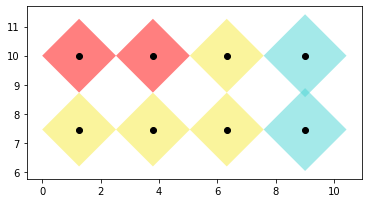

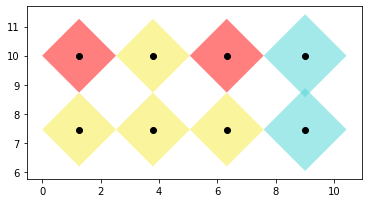

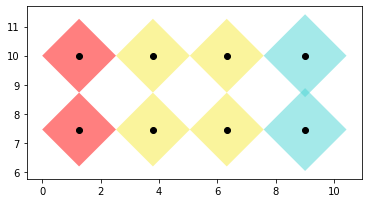

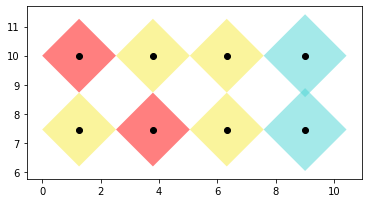

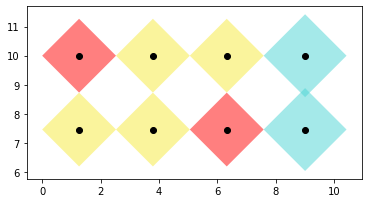

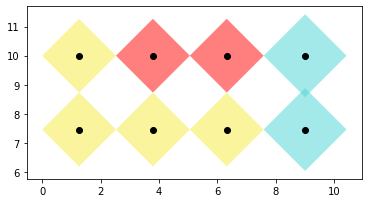

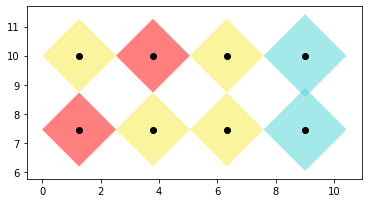

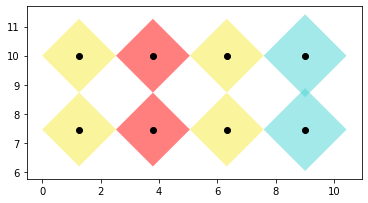

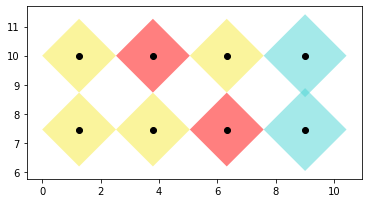

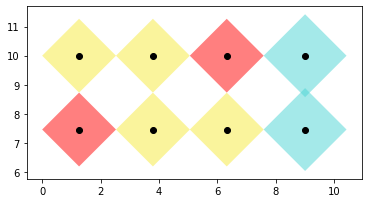

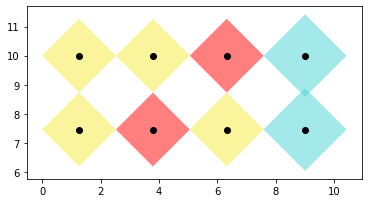

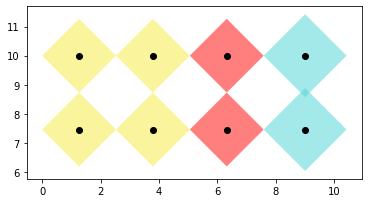

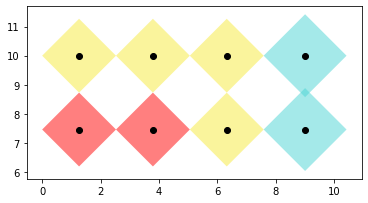

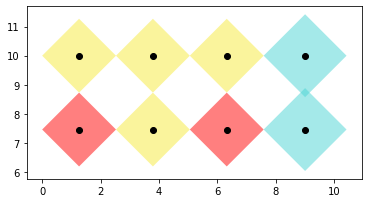

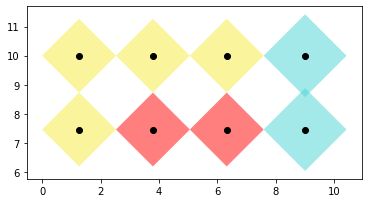

0.31000000000000283

In [55]:
#Example:

runCode(np.array(["In3+","Na+", "Cr2+"]), "Cl", 2,4, True, "InCrNaCombos.csv")

optimalCombo = ['In3+', 'Na+', 'Cr2+', 'Cr2+']
optimal Distance = 0.30999999999999917


All optimal combos = [['In3+', 'Na+', 'Cr2+', 'Cr2+'], ['Cr2+', 'Na+', 'In3+', 'Cr2+'], ['Cr2+', 'Na+', 'Cr2+', 'In3+']]
3





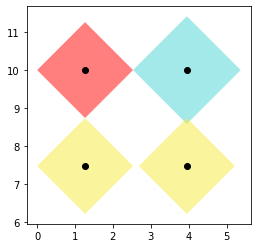

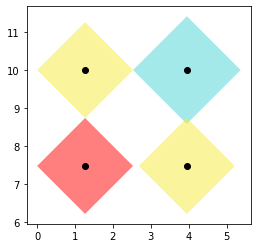

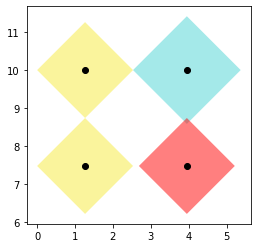

0.30999999999999917

In [56]:
runCode(np.array(["In3+","Na+", "Cr2+"]), "Cl", 2, 2)

optimalCombo = ['In3+', 'K+', 'Cr2+', 'Cr2+']
optimal Distance = 0.6400000000000001


All optimal combos = [['In3+', 'K+', 'Cr2+', 'Cr2+'], ['Cr2+', 'K+', 'In3+', 'Cr2+'], ['Cr2+', 'K+', 'Cr2+', 'In3+']]
3





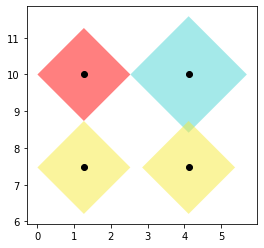

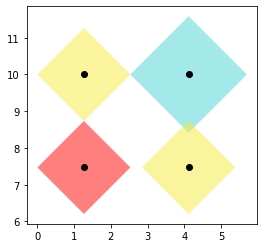

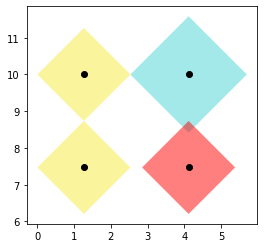

0.6400000000000001

In [57]:
runCode(np.array(["In3+","K+", "Cr2+"]), "Cl", 2, 2)

### - Use this method if you have a csv file with a list of ion set combinations (ex: All Ag-Bi combos) that you want to test out
### - this section will read in the csv of all the set combinations and perform the calculations on them
### - you can specify the halide you want to use for the bond lengths by changing the variable "x" (ex: x = "Cl: would also work)
### - allAgBiMinimalMismatches stores each set of ions and its smallest total mismatch (for comparison)


atomList = ['Bi3+' 'Ag+' 'Cu2+']
We don't have all of the bond lengths for this set.
Try a different set of ions or manually create the BondLengths and BondWidths dictionaries.



----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Mg2+']
optimalCombo = ['Mg2+', 'Ag+', 'Bi3+', 'Mg2+']
optimal Distance = 0.03999999999999959


All optimal combos = [['Mg2+', 'Ag+', 'Bi3+', 'Mg2+']]
1





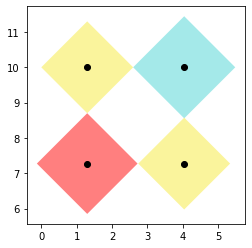




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Ca2+']
optimalCombo = ['Ca2+', 'Ca2+', 'Ag+', 'Bi3+']
optimal Distance = 0.029999999999998472


All optimal combos = [['Ca2+', 'Ca2+', 'Ag+', 'Bi3+']]
1





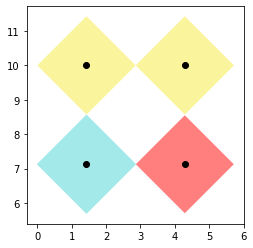




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Sr2+']
We don't have all of the bond lengths for this set.
Try a different set of ions or manually create the BondLengths and BondWidths dictionaries.



----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'V2+']
optimalCombo = ['Bi3+', 'V2+', 'V2+', 'Ag+']
optimal Distance = 0.03999999999999737


All optimal combos = [['Bi3+', 'V2+', 'V2+', 'Ag+']]
1





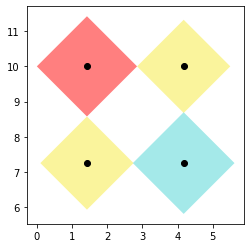




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Cr2+']
optimalCombo = ['Cr2+', 'Bi3+', 'Ag+', 'Cr2+']
optimal Distance = 0.03999999999999737


All optimal combos = [['Cr2+', 'Bi3+', 'Ag+', 'Cr2+']]
1





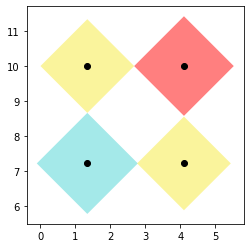




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Mn2+']
optimalCombo = ['Mn2+', 'Bi3+', 'Ag+', 'Mn2+']
optimal Distance = 0.03999999999999737


All optimal combos = [['Mn2+', 'Bi3+', 'Ag+', 'Mn2+']]
1





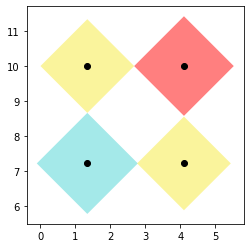




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Fe2+']
optimalCombo = ['Fe2+', 'Ag+', 'Bi3+', 'Fe2+']
optimal Distance = 0.03999999999999959


All optimal combos = [['Fe2+', 'Ag+', 'Bi3+', 'Fe2+']]
1





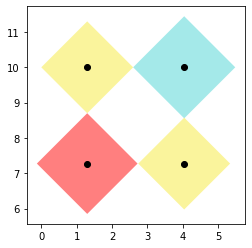




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Co2+']
We don't have all of the bond lengths for this set.
Try a different set of ions or manually create the BondLengths and BondWidths dictionaries.



----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Ni2+']
optimalCombo = ['Bi3+', 'Ni2+', 'Ni2+', 'Ag+']
optimal Distance = 0.040000000000000036


All optimal combos = [['Bi3+', 'Ni2+', 'Ni2+', 'Ag+'], ['Ni2+', 'Bi3+', 'Ag+', 'Ni2+']]
2





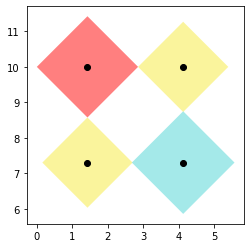

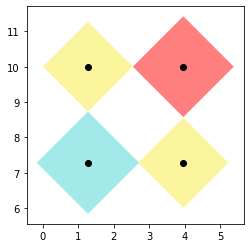




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Zn2+']
We don't have all of the bond lengths for this set.
Try a different set of ions or manually create the BondLengths and BondWidths dictionaries.



----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Cd2+']
optimalCombo = ['Cd2+', 'Bi3+', 'Ag+', 'Cd2+']
optimal Distance = 0.03999999999999959


All optimal combos = [['Cd2+', 'Bi3+', 'Ag+', 'Cd2+']]
1





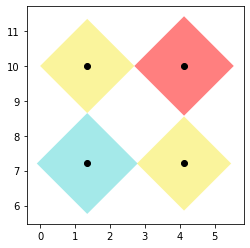




----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Sn2+']
We don't have all of the bond lengths for this set.
Try a different set of ions or manually create the BondLengths and BondWidths dictionaries.



----------------------------------------------------------------------------------------------------------------------------
atomList = ['Bi3+' 'Ag+' 'Pb2+']
optimalCombo = ['Pb2+', 'Bi3+', 'Ag+', 'Pb2+']
optimal Distance = 0.039999999999997815


All optimal combos = [['Pb2+', 'Bi3+', 'Ag+', 'Pb2+']]
1





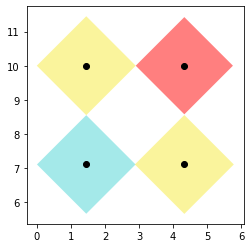




----------------------------------------------------------------------------------------------------------------------------


In [58]:
agBiCombos = pd.read_csv('AgBiCombinations.csv')
agBiCombos = agBiCombos.values.tolist()

x = "Br"
rows = 2
columns = 2

allAgBiMinimalMismatches = {}

for i in agBiCombos:
    atomList = np.array([i[2],i[0], i[1]])
    print("atomList = " + str(atomList))
    #atoms = atomList
  #  runCode(atomList, x, 2, 2)
    allAgBiMinimalMismatches[str(i)] = runCode(atomList, x, 2, 2)
  #  print("run code output" + str(runCode(atomList, x, 2, 2)))
    print("\n\n")
    print("----------------------------------------------------------------------------------------------------------------------------")



In [59]:
allAgBiMinimalMismatches

{"['Ag+', 'Cu2+', 'Bi3+']": 'Missing one or more bond length(s)',
 "['Ag+', 'Mg2+', 'Bi3+']": 0.03999999999999959,
 "['Ag+', 'Ca2+', 'Bi3+']": 0.029999999999998472,
 "['Ag+', 'Sr2+', 'Bi3+']": 'Missing one or more bond length(s)',
 "['Ag+', 'V2+', 'Bi3+']": 0.03999999999999737,
 "['Ag+', 'Cr2+', 'Bi3+']": 0.03999999999999737,
 "['Ag+', 'Mn2+', 'Bi3+']": 0.03999999999999737,
 "['Ag+', 'Fe2+', 'Bi3+']": 0.03999999999999959,
 "['Ag+', 'Co2+', 'Bi3+']": 'Missing one or more bond length(s)',
 "['Ag+', 'Ni2+', 'Bi3+']": 0.040000000000000036,
 "['Ag+', 'Zn2+', 'Bi3+']": 'Missing one or more bond length(s)',
 "['Ag+', 'Cd2+', 'Bi3+']": 0.03999999999999959,
 "['Ag+', 'Sn2+', 'Bi3+']": 'Missing one or more bond length(s)',
 "['Ag+', 'Pb2+', 'Bi3+']": 0.039999999999997815}